# Guided Project: Creating a Kaggle Workflow 

## Introducing Data Science Workflows

For this particular project, I will put everything I learned together and create a data science workflow. 

In [1]:
import pandas as pd 
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Preprocessing the Data 

In [2]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [3]:
def preprocess(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    for col in ['Age_categories','Fare_categories', 'Title', 'Cabin_type', 'Sex']:
        create_dummies(df, col)
    return df 

train = preprocess(train)
holdout = preprocess(holdout)

## Exploring the Data

In [4]:
cols = ['SibSp', 'Parch', 'Survived']
train_explore = train[cols].copy()
train_explore.info()
train_explore.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


,SibSp,Parch,Survived
count,891.000000,891.000000,891.000000
mean,0.523008,0.381594,0.383838
std,1.102743,0.806057,0.486592
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000
max,8.000000,6.000000,1.000000


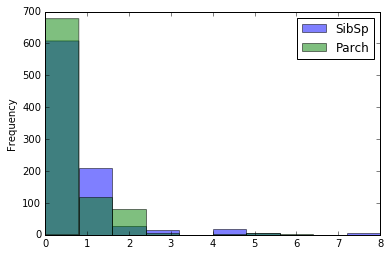

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 

train_explore.drop('Survived', axis = 1).plot.hist(alpha = 0.5, bins = 10)
plt.show()

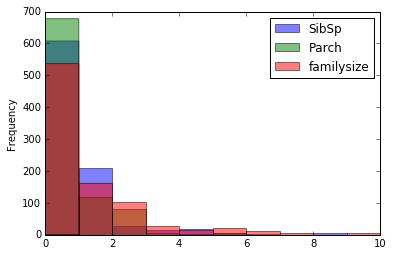

In [6]:
train_explore['familysize'] = train_explore[['SibSp', 'Parch']].sum(axis = 1)
train_explore.drop('Survived', axis = 1).plot.hist(alpha = 0.5, bins = 10)
plt.show()

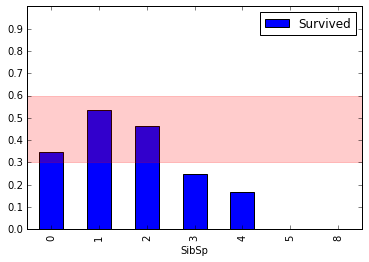

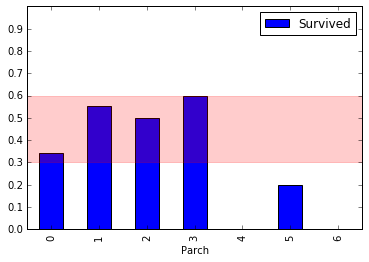

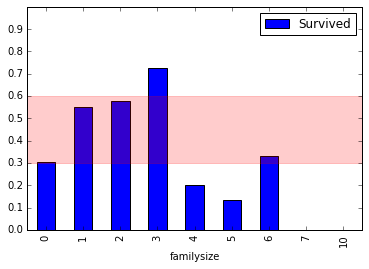

In [7]:
import numpy as np 

for col in train_explore.columns.drop('Survived'):
    pivot = train_explore.pivot_table(index = col, values = 'Survived')
    pivot.plot.bar(ylim = (0,1), yticks = np.arange(0,1,0.1))
    plt.axhspan(0.3,0.6, alpha = 0.2, color = 'red')
    plt.show()
                   

## Engineering New Features

From the graphs, it is shown that when I combined SibSp and Parch to a single column, only 30% of passengers who had no family survived. I will now create a new feature for if the passenger was alone making this a binary column of 1 and 0. 
    
   1) 1: Passenger had no family
   
   2) 0: Passenger had family

In [8]:
def feature_is_alone(df):
    df['familysize'] = df[['SibSp', 'Parch']].sum(axis = 1)
    df['isalone'] = 0
    df.loc[df['familysize'] == 0, 'isalone'] = 1
    df = df.drop('familysize', axis = 1)
    return df

train = feature_is_alone(train)
holdout = feature_is_alone(holdout)

## Selecting the Best-Performing Features

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df): 
    df = df.select_dtypes([np.number]).dropna(axis = 1)
    all_X = df.drop(['Survived', 'PassengerId'], axis = 1)
    all_y = df['Survived']
    clf = RandomForestClassifier(random_state = 1)
    selector = RFECV(clf, cv = 10)
    selector.fit(all_X, all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    return best_columns

columns = select_features(train)
    

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



## Selecting and Tuning Different Algorithms

I will now create a function for model selection and tuning. This particular function will implement three different algorithms and use grid search to train the model using different combinations of hyperparameters to find the optimal model. This can be done with a dictionary. In the dictionary there will be three components: 
    
   1) Model name
   
   2) Estimator of the model 
   
   3) Hyperparameter dictionary using grid search
   
I will then implement a for loop to iterate over the dictionaries. From there I will use GridSearchCV to find the best parameters. 

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    
    
    diction = [
        
        
        {'name':'Logistic Regression',
        'estimator': LogisticRegression(),
        'hyperparameters': 
        {'solver': ['newton-cg', 'lbfgs', 'liblinear']}}
    ,
        {'name' : 'K Nearest Neighbors',
        'estimator': KNeighborsClassifier(),
        'hyperparameters': 
        {
        'n_neighbors' : range(1,20,2),
        'weights' : ['distance', 'uniform'],
        'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
        'p' : [1,2]
        }}
    ,
        {
        'name': 'Random Forest',
        'estimator' : RandomForestClassifier(),
        'hyperparameters':
        {
        'n_estimators' : [4,6,9],
        'criterion' : ['entropy', 'gini'],
        'max_depth' : [2,5,10],
        'max_features' : ['log2', 'sqrt'],
        'min_samples_leaf' : [1,5,8],
        'min_samples_split' : [2,3,5]
        }}
    ]
    
    for d in diction:
        print(d['name'])
        grid = GridSearchCV(d['estimator'], param_grid = d['hyperparameters'], cv = 10)
        grid.fit(all_X, all_y)
        d['best_parameters'] = grid.best_params_
        d['best_score'] = grid.best_score_
        d['best_model'] = grid.best_estimator_
        
        print('Best score: {}'.format(d['best_score']))
        print('Best parameters: {}\n'.format(d['best_parameters']))
        
    return diction

final_result = select_model(train, columns)
    
    
    
    
    
    

Logistic Regression
Best score: 0.7014590347923682
Best parameters: {'solver': 'liblinear'}

K Nearest Neighbors
Best score: 0.6980920314253648
Best parameters: {'algorithm': 'brute', 'n_neighbors': 15, 'weights': 'distance', 'p': 1}

Random Forest
Best score: 0.7429854096520763
Best parameters: {'min_samples_leaf': 8, 'n_estimators': 6, 'max_features': 'sqrt', 'min_samples_split': 3, 'criterion': 'entropy', 'max_depth': 10}



## Make a Submission to Kaggle

In [11]:
def save_submission_file(model, columns, filename = 'submission.csv' ):
    holdout_data = holdout[columns]
    predictions = model.predict(holdout_data)
    
    submission = {
        'PassengerId' : holdout['PassengerId'],
        'Survived' : predictions
    }
    
    submission = pd.DataFrame(submission)
    submission.to_csv(filename, index = False)

best_model = final_result[2]['best_model']
save_submission_file(best_model, columns)